**План проекта**
* [1. Описание данных](#data_description)
    * [1.1 Загрузка данных и первый взгляд на них](#data_load)
    * [1.2 Гистограммы для числовых атрибутов](#data_hist)
    * [1.3 Создание отложенной выборки](#val_set)
* [2. Базовое решение](#base_des)
    * [2.1 Преобразование категориальных признаков](#dummies)
    * [2.2 Замена пропущенных значений](#mis_val_base)
    * [2.3 Построение базовой модели и её оценка](#base_mod)
* [3. Разведочный анализ данных (EDA)](#eda)
    * [3.1 Обработка выбросов](#outlier)
        * [3.1.1 HouseYear](#HouseYear)
        * [3.1.2 HouseFloor, Floor](#Floor)
        * [3.1.3 KitchenSquare](#KitchenSquare)
        * [3.1.4 Rooms](#Rooms)
        * [3.1.5 Square, LifeSquare](#Square)
    * [3.2 Создание класса DataPreprocessing](#DataPreprocessing)     


    

***Подключение библиотек и скриптов***

In [225]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [226]:
from scipy import stats

In [227]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [228]:
import matplotlib.style as style
style.use('fivethirtyeight')

matplotlib.rcParams.update({'font.size': 14})

***Пути к директориям и файлам***

In [229]:
DATASET_PATH = '../data/project_train.csv'
TEST_PATH = '../data/project_test.csv'
SUBM_PATH = '../data/sample_submission.csv'

***Вспомогательные функции***

1. 

In [230]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

## 1. Описание данных <a class='anchor' id='data_description'>

**Цель задачи** - предсказать стоимость недвижимости 

**Описание датасета**

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

Метрика: коэффициент детерминации
$ R^2=1−\frac{σ^2}{σ^2_y}\ $

### 1.1 Загрузка данных и первый взгляд на них <a class='anchor' id='data_load'>

In [443]:
df = pd.read_csv(DATASET_PATH)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [232]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


In [233]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Посмотрим на категориальные признаки:

In [234]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [235]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [236]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

**Пропущенные значения**

In [237]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [444]:
test_df = pd.read_csv(TEST_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [239]:
print('Строк в обучающей выборке:', df.shape[0])
print('Строк в тестовой выборке', test_df.shape[0])

Строк в обучающей выборке: 10000
Строк в тестовой выборке 5000


In [240]:
df.shape[1] - 1 == test_df.shape[1]

True

### 1.2 Гистограммы для числовых атрибутов <a class='anchor' id='data_hist'>

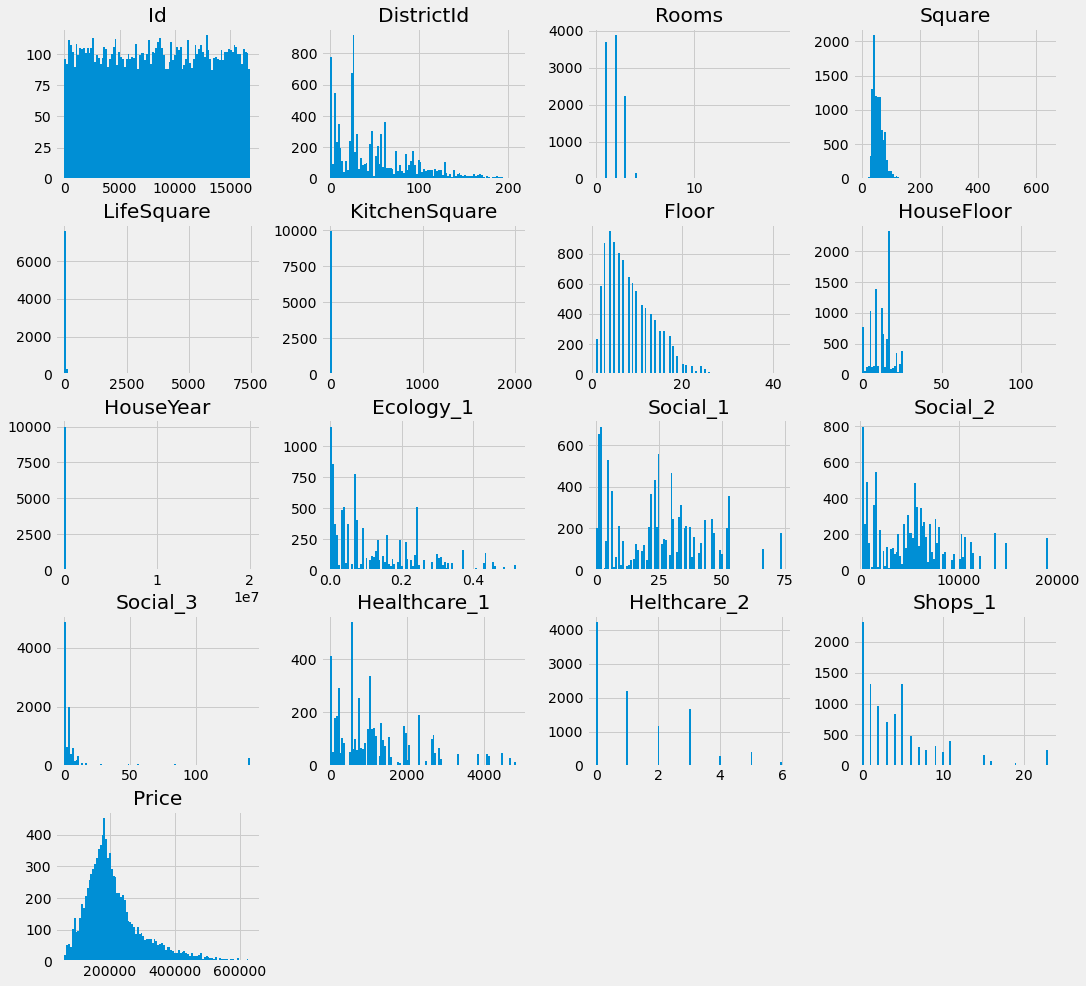

In [241]:
df.hist(bins=100, figsize=(16,16))
plt.show()

- Видно, что признаки 'LifeSquare', 'KitchenSquare', 'HouseYear' имеют выбросы.
- Атрибуты имеют разные масштабы.

### 1.3 Создание отложенной выборки (испытательного набора) <a class='anchor' id='val_set'>

В целях борьбы с переобучением сделаем стратифицированную выборку на основе площади объекта недвижимости, так как разумно предположить, что площадь является важным атрибутом для прогнозирования стоимости квартиры.

<AxesSubplot:>

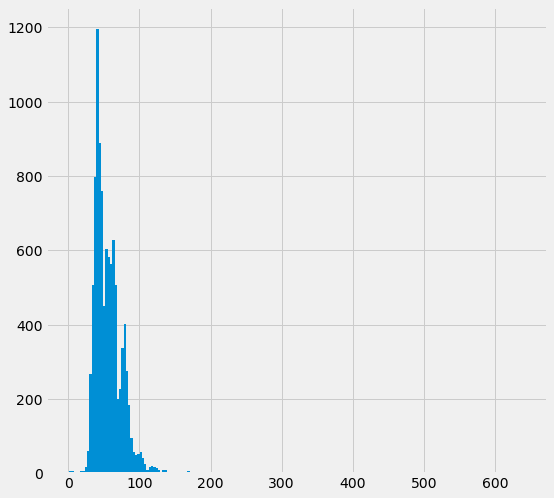

In [242]:
df.Square.hist(bins=200, figsize=(8,8))

Большинство значений площади квартир сгруппированы около 30 - 100 м^2 , но некторые выходят далеко за 120. Создадим атрибут категории дохода (0-30, 30-60, 60-90, 90-120, >120)

In [445]:
df['Square_cat'] = np.ceil(df.Square / 30)
df['Square_cat'].where(df['Square_cat'] < 5, 5.0, inplace=True)

In [244]:
df['Square_cat'].value_counts()

2.0    6249
3.0    3217
4.0     337
1.0     105
5.0      92
Name: Square_cat, dtype: int64

<AxesSubplot:>

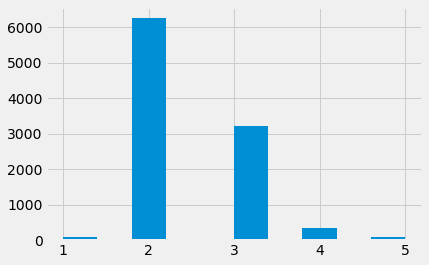

In [245]:
df['Square_cat'].hist()

In [446]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=28)
for train_index, test_index in split.split(df, df["Square_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [247]:
df["Square_cat"].value_counts() / len(df)

2.0    0.6249
3.0    0.3217
4.0    0.0337
1.0    0.0105
5.0    0.0092
Name: Square_cat, dtype: float64

In [248]:
def income_cat_proportions(data):
    return data["Square_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.2, random_state=28)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(df),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [249]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.0105,0.0105,0.0115,9.523810,0.000000
2.0,0.6249,0.6250,0.6305,0.896143,0.016003
3.0,0.3217,0.3220,0.3170,-1.460988,0.093255
4.0,0.0337,0.0335,0.0340,0.890208,-0.593472
5.0,0.0092,0.0090,0.0070,-23.913043,-2.173913


In [250]:
for set_ in (strat_train_set, strat_test_set, df):
    set_.drop("Square_cat", axis=1, inplace=True)

In [251]:
df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

## 2. Базовое решение <a class='anchor' id='base_des'>

In [252]:
temp_df = strat_train_set.copy()
temp_val_df = strat_test_set.copy()

temp_test_df = test_df.copy()

### 2.1  Преобразование категориальных признаков <a class='anchor' id='dummies'>

In [253]:
binary_to_numbers = {'A': 0, 'B': 1}

for set_ in (temp_df, temp_val_df, temp_test_df):
    set_['Ecology_2'] = set_['Ecology_2'].replace(binary_to_numbers)
    set_['Ecology_3'] = set_['Ecology_3'].replace(binary_to_numbers)
    set_['Shops_2'] = set_['Shops_2'].replace(binary_to_numbers)

### 2.2 Замена пропущенных значений <a class='anchor' id='mis_val_base'>

In [254]:
for set_ in (temp_df, temp_val_df, temp_test_df):
    print('-----')
    print(set_.isna().sum()[set_.isna().sum() > 0])

-----
LifeSquare      1713
Healthcare_1    3850
dtype: int64
-----
LifeSquare      400
Healthcare_1    948
dtype: int64
-----
LifeSquare      1041
Healthcare_1    2377
dtype: int64


**признак 'LifeSquare_nan'**

In [255]:
for set_ in (temp_df, temp_val_df, temp_test_df):
    set_['LifeSquare_nan'] = set_['LifeSquare'].isna() * 1

    condition = (set_['LifeSquare'].isna())

    set_.loc[condition, 'LifeSquare'] = set_.loc[condition, 'Square'] \
                                            - set_.loc[condition, 'KitchenSquare'] - 3

**признак 'Healthcare_1'**

Заменять пропущенные значения признака 'Healthcare_1' будем путём прогнозирования с помощью модели, обученной на имеющихся данных

Для начала посмотрим как каждый числовой атрибут связан с признаком 'Healthcare_1'

In [256]:
corr_matrix = temp_df.corr()

corr_matrix['Healthcare_1'].sort_values(ascending=False)

Healthcare_1      1.000000
DistrictId        0.321909
Helthcare_2       0.212779
Social_3          0.144826
Price             0.139008
Social_1          0.073249
Shops_1           0.061946
Social_2          0.047577
Rooms             0.038983
KitchenSquare     0.005628
Id                0.003325
HouseYear        -0.013460
Shops_2          -0.025856
Ecology_2        -0.026598
Square           -0.048190
Ecology_1        -0.049598
LifeSquare       -0.074536
Ecology_3        -0.106122
HouseFloor       -0.150664
Floor            -0.156208
LifeSquare_nan   -0.175731
Name: Healthcare_1, dtype: float64

In [257]:
temp_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'LifeSquare_nan'],
      dtype='object')

Так как логично предположить, что значения признака Healthcare1 не зависят от таких атрибутов, как 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', оставим только те которые, скорее всего, помогут определить пропущенные значения

In [258]:
columns = ['Ecology_1',  'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 
           'Shops_1']

for set_ in (temp_df, temp_val_df, temp_test_df):
    set_['Health_nan'] = set_['Healthcare_1'].isna() * 1

# Датсеты, в которых надо заменить пропущенные значения:
health_train_null = temp_df[temp_df.Health_nan == 1][columns]
health_val_null = temp_val_df[temp_val_df.Health_nan == 1][columns]

health_test_null = temp_test_df[temp_test_df.Health_nan == 1][columns]

**Обучение модели**

In [259]:
X = temp_df[temp_df.Health_nan == 0].drop(columns='Healthcare_1')[columns]
y = temp_df[temp_df.Health_nan == 0]['Healthcare_1']

In [260]:
X.shape, y.shape

((4150, 9), (4150,))

In [261]:
dt_model = DecisionTreeRegressor(random_state=28)

In [262]:
cv_score_dt = cross_val_score(dt_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=28))
cv_score_dt

array([0.99989186, 1.        , 0.99799141])

Результаты обнадёживающие, оставляем эту модель и рассчитываем с помощью неё пропущенные значения признака 'Healthcare_1'

In [263]:
dt_model.fit(X, y)

health_train_pred = dt_model.predict(health_train_null)
health_val_pred = dt_model.predict(health_val_null)

health_test_pred = dt_model.predict(health_test_null)

In [264]:
len(health_train_pred) + len(health_test_pred)

6227

In [265]:
feature_importances = pd.DataFrame(zip(X.columns, dt_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
5,Social_3,0.311802
4,Social_2,0.248198
3,Social_1,0.160854
0,Ecology_1,0.141030
7,Shops_1,0.089445
6,Helthcare_2,0.048613
8,Shops_2,0.000057
1,Ecology_2,0.000000
2,Ecology_3,0.000000


In [266]:
health_train_pred

array([  46., 1015., 1015., ...,   46., 1547.,  350.])

In [267]:
health_train_null.index

Int64Index([5767, 4430, 5911, 6095, 7342, 5011,  757, 4819, 4496, 9638,
            ...
            3268, 9246, 8207, 3373, 6398, 5285, 7369, 4497,  284, 2194],
           dtype='int64', length=3850)

Заполняем пропущенные значения предсказанными моделью

In [268]:
health_train = pd.Series(health_train_pred, index=health_train_null.index)
health_val = pd.Series(health_val_pred, index=health_val_null.index)

health_test = pd.Series(health_test_pred, index=health_test_null.index)

In [269]:
temp_df['Healthcare_1'].fillna(health_train, inplace=True)
temp_val_df['Healthcare_1'].fillna(health_val, inplace=True)

temp_test_df['Healthcare_1'].fillna(health_test, inplace=True)

In [270]:
temp_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Health_nan
7579,2149,62,3.0,61.586468,46.508579,6.0,7,9.0,1979,0.037178,...,52,11217,1,2300.0,1,7,1,240804.697900,0,0
5837,3410,87,3.0,61.052434,45.511257,6.0,3,9.0,1978,0.000000,...,39,8647,0,810.0,0,5,1,284057.268711,0,0
9391,16187,6,3.0,82.136953,78.136953,1.0,3,17.0,1977,0.243205,...,5,1564,0,540.0,0,0,1,214324.131855,1,0
313,14565,53,1.0,39.246823,35.246823,1.0,4,19.0,1977,0.049637,...,34,7759,0,229.0,1,3,1,203671.175291,1,0
5767,8694,8,2.0,44.966817,28.410299,6.0,3,9.0,1979,0.219006,...,28,6746,3,46.0,1,4,1,200029.483919,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3414,10283,19,3.0,77.469848,48.756854,9.0,3,6.0,1957,0.309479,...,35,7715,4,990.0,0,6,1,293459.205444,0,0
4497,12628,78,1.0,34.307988,22.568769,6.0,6,9.0,1973,0.219006,...,28,6746,3,46.0,1,4,1,88176.739773,0,1
284,1724,74,1.0,36.523264,32.523264,1.0,3,17.0,1977,0.075779,...,6,1437,3,1547.0,0,2,1,127047.787553,1,1
2670,16381,28,1.0,35.637992,19.382057,9.0,4,12.0,1965,0.118537,...,30,6207,1,1183.0,1,0,1,184243.992920,0,0


In [271]:
for set_ in (temp_df, temp_val_df, temp_test_df):
    print(set_.isna().sum().sum())

0
0
0


### 2.3  Построение базовой модели и её оценка <a class='anchor' id='base_mod'>

In [272]:
temp_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'LifeSquare_nan',
       'Health_nan'],
      dtype='object')

In [273]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'LifeSquare_nan',
       'Health_nan']

target_name = 'Price'

In [274]:
X_train = temp_df[feature_names]
y_train = temp_df[target_name]

X_valid = temp_val_df[feature_names]
y_valid = temp_val_df[target_name]

In [275]:
rf_model = RandomForestRegressor(random_state=28, criterion='mse', n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=28)

Train R2:	0.962
Test R2:	0.741


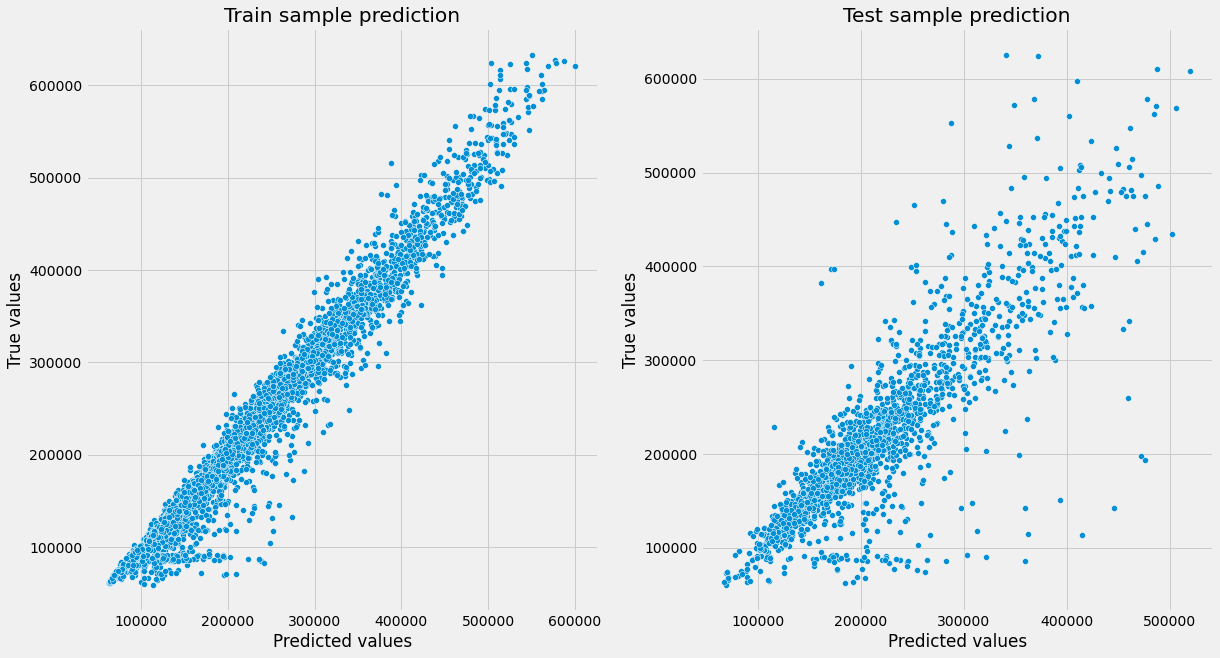

In [276]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Базовая модель получилась переобученной

In [277]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.399698
11,Social_1,0.134961
1,Rooms,0.062262
12,Social_2,0.059690
13,Social_3,0.053016
0,DistrictId,0.042647
3,LifeSquare,0.040581
8,Ecology_1,0.039042
7,HouseYear,0.036602
14,Healthcare_1,0.028034


In [278]:
temp_test_df.shape

(5000, 21)

In [279]:
temp_df.shape

(8000, 22)

In [280]:
submit = pd.read_csv(SUBM_PATH)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [281]:
predictions = rf_model.predict(temp_test_df[feature_names])
predictions

array([161757.74441568, 116925.63281067, 139123.95399944, ...,
       146322.08637961, 194865.98900505, 252604.78595066])

In [282]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,161757.744416
1,5925,116925.632811
2,960,139123.953999
3,3848,122472.211282
4,746,212246.938494


In [283]:
submit.to_csv('base_submit.csv', index=False, header = 1)

In [284]:
score_base_rf = 0.73156
print('Результат на kaggle (Public Score):', score_base_rf)

Результат на kaggle (Public Score): 0.73156


## 3. Разведочный анализ данных (EDA - Exploratory Data Analysis) <a class='anchor' id='eda'>

Стратегия замены пропущенных значений описана выше: [2.2 Замена пропущенных значений](#mis_val_base)

### 3.1 Обработка выбросов  <a class='anchor' id='outlier'>

In [285]:
strat_train_set['Id'] = strat_train_set['Id'].astype(str)
strat_train_set['DistrictId'] = strat_train_set['DistrictId'].astype(str)

In [286]:
columns = list(strat_train_set.dtypes[strat_train_set.dtypes != object].index)

Так как среднее арифметическое чувствительно к выбросам в отличии от медианы, то можно по разности между ними судить о том, много ли выбросов в признаке.

In [287]:
lst = []
for col in columns:
    mn = strat_train_set[col].mean()
    md = strat_train_set[col].median()
    lst.append([col, mn, md, mn / md])

In [288]:
mn_md_df = pd.DataFrame(lst, columns = ['Feature', 'mean', 'median', 'delta'])
mn_md_df.sort_values(by='delta', ascending=False)

,Feature,mean,median,delta
10,Social_3,7.915875,2.000000,3.957937
6,HouseYear,4491.296500,1977.000000,2.271774
7,Ecology_1,0.119954,0.075779,1.582949
13,Shops_1,4.177250,3.000000,1.392417
12,Helthcare_2,1.322375,1.000000,1.322375
11,Healthcare_1,1153.841446,900.000000,1.282046
4,Floor,8.530875,7.000000,1.218696
14,Price,213921.270870,191777.349232,1.115467
2,LifeSquare,36.265409,32.729196,1.108045
1,Square,56.314587,52.456064,1.073557


<AxesSubplot:>

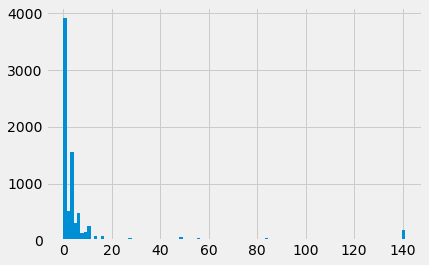

In [289]:
strat_train_set['Social_3'].hist(bins=100)

In [290]:
set(strat_train_set[strat_train_set['Social_3']==141].DistrictId)

{'104', '174', '189', '30', '4', '43'}

#### 3.1.1 HouseYear  <a class='anchor' id='HouseYear'>

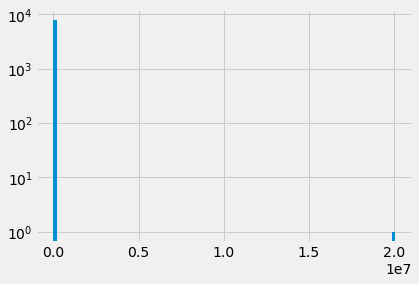

In [291]:
plt.hist(strat_train_set['HouseYear'], bins=100, log=True)
plt.show()

In [292]:
strat_train_set['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
6073        2020
5412        2020
1976        2020
          ...   
485         1917
7610        1916
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 8000, dtype: int64

In [293]:
strat_train_set[strat_train_set['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8828,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096
9163,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396


In [294]:
strat_train_set.loc[strat_train_set['HouseYear'] == 20052011, 'HouseYear'] = 2011
strat_train_set.loc[strat_train_set['HouseYear'] == 4968, 'HouseYear'] = 1968

#### 3.1.2 HouseFloor, Floor  <a class='anchor' id='Floor'>

In [295]:
strat_train_set['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  37.,
        38.,  39.,  40.,  44.,  47.,  48.,  99., 117.])

In [296]:
strat_train_set[strat_train_set.HouseYear < 2000]['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  30.,  40.,  99., 117.])

В признаке 'HouseFloor' явно выбросы, особенно если учесть, что до 2003 самым высоким жилым зданием в Москве был Жилой дом на Котельнической набережной этажностью 32

In [89]:
strat_train_set['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [223]:
strat_train_set[strat_train_set.HouseYear < 2000]['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 33], dtype=int64)

Значения признака 'Floor' выглядят адекватно. Ничего с ним делать не будем

In [298]:
(strat_train_set['Floor'] > strat_train_set['HouseFloor']).sum()

1468

Также придётся побороться со значениями в которых этаж, на котором находится квартира, выше этжности дома. В таких случаях будем просто заменять этажность дома на значение атрибута 'Floor'.

In [300]:
strat_train_set.loc[(strat_train_set['HouseFloor'] < 4) & (strat_train_set.HouseYear < 1960)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1026,7275,95,4.0,99.039161,71.575839,11.0,2,3.0,1942,0.000699,B,B,14,3369,24,4129.0,0,3,B,624156.003381
8434,11017,101,3.0,55.476882,37.698072,6.0,7,3.0,1959,0.225825,A,B,41,6558,7,1548.0,3,2,B,118410.974059
3391,1494,124,3.0,70.363852,47.861824,7.0,3,3.0,1952,0.169091,B,B,19,3856,10,NaN,2,5,B,259143.174754
2314,7505,2,2.0,53.055026,26.925534,7.0,5,3.0,1955,0.035145,B,B,42,9292,3,2620.0,0,3,B,212894.088951
5509,9454,22,2.0,50.072347,33.357161,7.0,3,3.0,1951,0.118537,B,B,30,6207,1,1183.0,1,0,B,193062.427929
2103,4671,124,2.0,61.875122,37.481412,9.0,2,3.0,1952,0.169091,B,B,19,3856,10,NaN,2,5,B,306525.883704
7106,7018,120,3.0,87.848494,56.589076,11.0,2,3.0,1931,0.341072,B,B,27,5664,48,2300.0,3,11,B,402075.431031


Врядли после 1960 года в Москве строили 1-, 2- этажные дома. А в этом наборе данных нет таких домов, построенных до 1960. Поэтому 1-, 2- этажные дома будем считать выбросом.

In [140]:
strat_train_set['HouseFloor_outlier'] = 0
strat_train_set.loc[strat_train_set['HouseFloor'] < 3, 'HouseFloor_outlier'] = 1
strat_train_set.loc[strat_train_set['Floor'] > strat_train_set['HouseFloor'], 'HouseFloor_outlier'] = 1
strat_train_set.loc[(strat_train_set.HouseYear < 2002) & (strat_train_set.HouseFloor > 32), 'HouseFloor_outlier'] = 1

Из выбросов сделаем пропущенные значения

In [141]:
strat_train_set.loc[strat_train_set['HouseFloor_outlier'] == 1, 'HouseFloor'] = np.nan

Заменять пропущенные значения средней этажностью домов такого же года постройки

In [301]:
strat_train_set['HouseFloor'].fillna(
   strat_train_set.groupby(['HouseYear'])['HouseFloor'].transform(lambda x: np.rint(x.mean())
    ), inplace=True)

# оставшиеся nan заменим значением 'Floor'
exp['HouseFloor'].fillna(strat_train_set.Floor, inplace=True)

In [302]:
(strat_train_set['Floor'] > strat_train_set['HouseFloor']).sum()

1468

In [303]:
strat_train_set.loc[strat_train_set['Floor'] > strat_train_set['HouseFloor'], 
                    'HouseFloor'] = strat_train_set.Floor

In [304]:
(strat_train_set['Floor'] > strat_train_set['HouseFloor']).sum()

0

In [305]:
strat_train_set['HouseFloor'].isna().sum()

0

#### 3.1.3 KitchenSquare  <a class='anchor' id='KitchenSquare'> 

In [307]:
strat_train_set['KitchenSquare'].value_counts()

1.0       1976
8.0       1027
5.0        937
10.0       853
6.0        842
9.0        669
0.0        559
7.0        493
12.0       208
11.0       182
13.0        52
14.0        41
4.0         31
15.0        27
3.0         16
16.0        13
20.0        12
17.0         9
19.0         7
18.0         5
30.0         2
2.0          2
51.0         2
37.0         2
58.0         2
41.0         2
22.0         2
36.0         1
26.0         1
48.0         1
2014.0       1
40.0         1
23.0         1
35.0         1
123.0        1
78.0         1
54.0         1
27.0         1
29.0         1
25.0         1
62.0         1
31.0         1
63.0         1
112.0        1
21.0         1
42.0         1
75.0         1
39.0         1
73.0         1
1970.0       1
32.0         1
72.0         1
43.0         1
60.0         1
Name: KitchenSquare, dtype: int64

In [309]:
strat_train_set['KitchenSquare'].quantile(.975), strat_train_set['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [310]:
condition = (strat_train_set['KitchenSquare'].isna()) \
             | (strat_train_set['KitchenSquare'] > strat_train_set['KitchenSquare'].quantile(.975))
        
strat_train_set.loc[condition, 'KitchenSquare'] = strat_train_set['KitchenSquare'].median()

strat_train_set.loc[strat_train_set['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [311]:
strat_train_set['KitchenSquare'].value_counts()

3.0     2553
8.0     1027
6.0      995
5.0      937
10.0     853
9.0      669
7.0      493
12.0     208
11.0     182
13.0      52
4.0       31
Name: KitchenSquare, dtype: int64

#### 3.1.4 Rooms  <a class='anchor' id='Rooms'>

In [312]:
strat_train_set['Rooms'].value_counts()

2.0     3112
1.0     2967
3.0     1776
4.0      119
5.0       15
0.0        8
19.0       1
10.0       1
6.0        1
Name: Rooms, dtype: int64

In [321]:
strat_train_set['Rooms_outlier'] = 0
strat_train_set.loc[strat_train_set['Rooms'] == 0, 'Rooms_outlier'] = 1
strat_train_set.loc[strat_train_set['Rooms'] == 0, 'Rooms'] = 1

In [335]:
strat_train_set.loc[strat_train_set['Rooms'] > 5, 'Rooms_outlier'] = 1
strat_train_set.loc[strat_train_set['Rooms'] > 5, 'Rooms'] = 1

In [338]:
strat_train_set.loc[(strat_train_set['Rooms'] >= 4) & (strat_train_set['Square'] < 50), 'Rooms_outlier'] = 1
strat_train_set.loc[(strat_train_set['Rooms'] >= 4) & (strat_train_set['Square'] < 50), 'Rooms'] = 1

In [343]:
strat_train_set['Rooms'].value_counts()

2.0    3112
1.0    2980
3.0    1776
4.0     119
5.0      13
Name: Rooms, dtype: int64

#### 3.1.5 Square, LifeSquare  <a class='anchor' id='Square'>

Заменим пропущенные значения

In [344]:
strat_train_set['LifeSquare_nan'] = strat_train_set['LifeSquare'].isna() * 1

condition = (strat_train_set['LifeSquare'].isna()) \
             & (~strat_train_set['Square'].isna()) \
             & (~strat_train_set['KitchenSquare'].isna())
        
strat_train_set.loc[condition, 'LifeSquare'] = strat_train_set.loc[condition, 'Square'] \
                                            - strat_train_set.loc[condition, 'KitchenSquare'] - 5

In [345]:
strat_train_set['LifeSquare'].isna().sum()

0

In [349]:
strat_train_set[strat_train_set.LifeSquare > strat_train_set.Square]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,room_sq,Rooms_outlier,LifeSquare_nan
4496,15744,34,1.0,1.988943,2.642219,3.0,21,21.0,1977,0.069753,...,13670,4,NaN,1,11,B,458378.777006,1.988943,0,0
161,6782,45,1.0,2.954309,5.257278,3.0,3,3.0,1977,0.195781,...,5212,6,NaN,3,2,B,438005.182323,2.954309,0,0
5265,8386,27,2.0,62.067272,63.456181,10.0,3,17.0,2017,0.017647,...,469,0,NaN,0,0,B,178467.117151,31.033636,0,0
4105,14322,1,2.0,62.411905,63.593900,3.0,24,24.0,1977,0.007122,...,264,0,NaN,0,1,B,209817.034644,31.205953,0,0
7819,15840,1,1.0,43.764463,43.981998,3.0,2,2.0,2019,0.007122,...,264,0,NaN,0,1,B,142003.769940,43.764463,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,2137,9,2.0,46.469859,50.703196,9.0,2,12.0,1966,0.310199,...,2748,1,NaN,0,0,B,159286.262162,23.234930,0,0
8900,16136,6,2.0,52.534282,56.961780,3.0,17,17.0,2016,0.243205,...,1564,0,540.0,0,0,B,145428.851540,26.267141,0,0
7419,5443,5,1.0,48.514321,49.922828,3.0,16,24.0,2017,0.150818,...,3433,4,2643.0,4,5,B,290958.689421,48.514321,0,0
8863,9639,73,1.0,51.329603,53.966051,3.0,11,11.0,1977,0.042032,...,6856,84,1940.0,2,5,B,445920.620104,51.329603,0,0


Странно, если площадь квартиры меньше 10. Такие данные будем считать выбросом, обрабатывать их будем следующем образом:
- если жилая площадь больше 10, то общую площадь заменим на сумму жилой, кухни + 5
- если жилая площадь меньше 10, то общую площадь заменим на медиану площади квартир того же года и такого же количества комнат

In [357]:
strat_train_set[strat_train_set.Square < 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,room_sq,Rooms_outlier,LifeSquare_nan,Square_outlier


In [351]:
strat_train_set['Square_outlier'] = 0

In [354]:
strat_train_set.loc[(strat_train_set['Square'] < 10) & (strat_train_set['LifeSquare'] > 10), 'Square_outlier'] = 1
strat_train_set.loc[(strat_train_set['Square'] < 10) & (strat_train_set['LifeSquare'] > 10), 'Square'] = \
                          strat_train_set['LifeSquare']  +  strat_train_set['KitchenSquare'] + 5

In [356]:
strat_train_set.loc[(strat_train_set['Square'] < 10) & (strat_train_set['LifeSquare'] <= 10), 'Square_outlier'] = 1
strat_train_set.loc[(strat_train_set['Square'] < 10) & (strat_train_set['LifeSquare'] <= 10), 'Square'] = np.nan

strat_train_set['Square'].fillna(
   strat_train_set.groupby(['HouseYear', 'Rooms'])['Square'].transform(lambda x: x.median()), inplace=True)

In [358]:
strat_train_set[strat_train_set['Square_outlier'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,room_sq,Rooms_outlier,LifeSquare_nan,Square_outlier
4496,15744,34,1.0,44.401671,2.642219,3.0,21,21.0,1977,0.069753,...,4,NaN,1,11,B,458378.777006,1.988943,0,0,1
161,6782,45,1.0,44.401671,5.257278,3.0,3,3.0,1977,0.195781,...,6,NaN,3,2,B,438005.182323,2.954309,0,0,1
9869,3224,27,1.0,44.401671,0.873147,3.0,1,1.0,1977,0.017647,...,0,NaN,0,0,B,126596.941798,2.377248,1,0,1
7470,14786,1,1.0,44.401671,4.525736,3.0,3,3.0,1977,0.007122,...,0,NaN,0,1,B,181434.825589,1.136859,0,0,1
9067,13265,1,3.0,82.767964,79.767964,3.0,6,17.0,1977,0.007122,...,0,NaN,0,1,B,237716.681261,1.607893,0,0,1
7033,1748,88,2.0,70.628717,67.628717,3.0,24,24.0,1977,0.127376,...,3,NaN,3,9,B,412511.088764,2.748531,0,0,1
328,4504,27,3.0,85.139016,5.610772,3.0,8,19.0,2016,0.211401,...,0,NaN,0,1,B,161379.067034,1.463444,0,0,1
8805,10527,27,1.0,43.805837,40.805837,3.0,10,17.0,2013,0.211401,...,0,NaN,0,1,B,97560.720383,4.380726,0,0,1
1401,9487,5,1.0,44.401671,5.549458,3.0,1,1.0,1977,0.150818,...,4,2643.0,4,5,B,369472.403061,5.129222,0,0,1
5009,11526,27,1.0,44.401671,1.969969,3.0,18,18.0,1977,0.011654,...,0,NaN,0,0,B,107604.269441,4.633498,0,0,1


Есть квартиры с неправдоподбной жилой площадью. Если LifeSquare < 0.25 * Square, то жилую площадь заменим на 0,5 * Square

In [378]:
strat_train_set[strat_train_set['LifeSquare'] < 0.25 * strat_train_set['Square']].LifeSquare.sort_values()

Series([], Name: LifeSquare, dtype: float64)

In [379]:
strat_train_set.loc[strat_train_set['LifeSquare'] < 0.25 * strat_train_set['Square'], 'LifeSquare_nan'] = 1
strat_train_set.loc[strat_train_set['LifeSquare'] < 0.25 * strat_train_set['Square'], 'LifeSquare'] = \
                                                            0.5 * strat_train_set['Square']

### 3.2 Создание класса DataPreprocessing  <a class='anchor' id='DataPreprocessing'>

In [447]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.dt_model = DecisionTreeRegressor(random_state=28)
        self.columns = ['Ecology_1',  'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1']
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        
        X['Health_nan'] = X['Healthcare_1'].isna() * 1
        
                
        X_ = X[X.Health_nan == 0].drop(columns='Healthcare_1')[self.columns]
        y_ = X[X.Health_nan == 0]['Healthcare_1']
        
        
        self.dt_model.fit(X_, y_)
        
    def transform(self, X):
        """Трансформация данных"""

        # HouseYear
        X.loc[X['HouseYear'] == 20052011, 'HouseYear'] = 2011
        X.loc[X['HouseYear'] == 4968, 'HouseYear'] = 1968
        
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 5
        
        # Square
        X['Square_outlier'] = 0

        X.loc[(X['Square'] < 10) & (X['LifeSquare'] > 10), 'Square_outlier'] = 1
        X.loc[(X['Square'] < 10) & (X['LifeSquare'] > 10), 'Square'] = \
                          X['LifeSquare']  +  X['KitchenSquare'] + 5
        
        X.loc[(X['Square'] < 10) & (X['LifeSquare'] <= 10), 'Square_outlier'] = 1
        X.loc[(X['Square'] < 10) & (X['LifeSquare'] <= 10), 'Square'] = np.nan

        X['Square'].fillna(
        X.groupby(['HouseYear', 'Rooms'])['Square'].transform(lambda x: x.median()), inplace=True)
        
        # LifeSquare again
        X.loc[X['LifeSquare'] < 0.25 * X['Square'], 'LifeSquare_nan'] = 1
        X.loc[X['LifeSquare'] < 0.25 * X['Square'], 'LifeSquare'] = 0.5 * X['Square']
                
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[X['Rooms'] == 0, 'Rooms_outlier'] = 1
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        
        X.loc[X['Rooms'] > 5, 'Rooms_outlier'] = 1
        X.loc[X['Rooms'] > 5, 'Rooms'] = 1
        
        X.loc[(X['Rooms'] >= 4) & (X['Square'] < 50), 'Rooms_outlier'] = 1
        X.loc[(X['Rooms'] >= 4) & (X['Square'] < 50), 'Rooms'] = 1
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] < 3, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        X.loc[(X.HouseYear < 2002) & (X.HouseFloor > 32), 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor_outlier'] == 1, 'HouseFloor'] = np.nan
        
        X['HouseFloor'].fillna(
        X.groupby(['HouseYear'])['HouseFloor'].transform(lambda x: np.rint(x.median())), inplace=True)
        X['HouseFloor'].fillna(X.Floor, inplace=True)
        X.loc[X['Floor'] > X['HouseFloor'],'HouseFloor'] = X.Floor
        
        # Healthcare_1
        X['Health_nan'] = X['Healthcare_1'].isna() * 1
        health_train_null = X[X.Health_nan == 1][self.columns]
        
        health_train_pred = self.dt_model.predict(health_train_null)    
        
        health_train = pd.Series(health_train_pred, index=health_train_null.index)
        
        X['Healthcare_1'].fillna(health_train, inplace=True)

#        X.fillna(self.medians, inplace=True)
        
        return X

In [ ]:
target_name = 'Price'

In [448]:
X = strat_train_set.drop(columns=['Price', 'Square_cat'])

y = strat_train_set['Price']

In [449]:
preprocessor = DataPreprocessing()
preprocessor.fit(strat_train_set)

In [450]:
X_train = preprocessor.transform(X)
#X_valid = preprocessor.transform(strat_test_set)
test_df = preprocessor.transform(test_df)

In [451]:
X_train.shape, X_valid.shape, test_df.shape

((8000, 24), (2000, 26), (5000, 24))

In [ ]:
rf_model = RandomForestRegressor(random_state=28, n_jobs=-1)
rf_model.fit(X_train, y_train)

In [453]:
binary_to_numbers = {'A': 0, 'B': 1}

for set_ in (X_train, test_df):
    set_['Ecology_2'] = set_['Ecology_2'].replace(binary_to_numbers)
    set_['Ecology_3'] = set_['Ecology_3'].replace(binary_to_numbers)
    set_['Shops_2'] = set_['Shops_2'].replace(binary_to_numbers)

In [454]:
cv_score_dt = cross_val_score(rf_model, X_train, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=28))
cv_score_dt

array([0.71580423, 0.71580123, 0.71884224])

In [455]:
predictions = rf_model.predict(test_df)
predictions

ValueError: Number of features of the model must match the input. Model n_features is 20 and input n_features is 24 

In [424]:
strat_train_set.shape

(8000, 26)

In [427]:
test_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'LifeSquare_nan', 'Square_outlier',
       'Rooms_outlier', 'HouseFloor_outlier', 'Health_nan'],
      dtype='object')

In [428]:
X_train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'Square_cat',
       'Health_nan', 'LifeSquare_nan', 'Square_outlier', 'Rooms_outlier',
       'HouseFloor_outlier'],
      dtype='object')

In [425]:
X_train.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Healthcare_1          0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
Square_cat            0
Health_nan            0
LifeSquare_nan        0
Square_outlier        0
Rooms_outlier         0
HouseFloor_outlier    0
dtype: int64

In [381]:
strat_train_set['room_sq'] = strat_train_set['Square'] / strat_train_set['Rooms']

In [382]:
strat_train_set['room_sq'].describe()

count    8000.000000
mean       32.671810
std        11.987107
min         4.594955
25%        25.638274
50%        30.867572
75%        39.133825
max       409.425181
Name: room_sq, dtype: float64

In [383]:
strat_train_set['room_sq'].quantile(.995), strat_train_set['room_sq'].quantile(.005)

(69.13758116173133, 16.993650168945965)

In [384]:
strat_train_set[strat_train_set['room_sq'] < 16]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,room_sq,Rooms_outlier,LifeSquare_nan,Square_outlier,LifeSquare_outlier
5520,4352,104,2.0,28.517666,15.565872,3.0,7,7.0,1931,0.000078,...,1046.0,3,23,B,197245.267664,14.258833,0,0,0,0
922,5913,90,3.0,44.418467,21.107737,8.0,10,15.0,1973,0.265089,...,1937.0,3,2,B,214431.006851,14.806156,0,0,0,0
5521,2748,143,3.0,46.388203,29.716007,5.0,3,5.0,1962,0.049863,...,75.0,3,1,B,255479.601949,15.462734,0,0,0,0
9332,3943,85,4.0,63.147414,46.777964,6.0,6,9.0,1979,0.037178,...,2300.0,1,7,B,250971.663904,15.786853,0,0,0,0
3521,8162,27,3.0,46.295821,40.295821,3.0,7,25.0,2016,0.072158,...,NaN,0,0,A,141657.045013,15.431940,0,1,0,0
8501,12927,62,2.0,17.414181,11.414181,3.0,4,20.0,1977,0.072158,...,NaN,0,0,A,180750.471749,8.707091,0,1,0,0
3686,15877,57,3.0,16.547242,16.698571,8.0,5,5.0,1962,0.133215,...,1406.0,3,4,A,77835.185808,5.515747,0,0,0,0
228,13727,27,3.0,47.821321,47.015083,3.0,10,25.0,1977,0.072158,...,NaN,0,0,A,143244.415307,15.940440,0,0,0,0
6619,11388,27,3.0,46.923652,40.923652,3.0,24,24.0,1977,0.072158,...,NaN,0,0,A,149404.835436,15.641217,0,1,0,0
9656,3508,27,3.0,46.126590,45.825691,3.0,9,25.0,2013,0.072158,...,NaN,0,0,A,137578.163912,15.375530,0,0,0,0


In [83]:
strat_train_set[strat_train_set['DistrictId'] == '109'].HouseYear

566         1979
2197        1965
3019        1994
8589        2009
3056        2001
7584        1968
8124        1978
9566        1995
4826        1996
7183        1996
5438        1962
7963        2001
6540        1999
5933        1966
9449        2002
1205        1990
3115        1988
9772        2011
8402        1965
7014        1964
5809        1985
6669        1999
2309        1979
9880        1982
9163    20052011
6385        1965
1865        2002
9411        1987
5948        1980
8025        2012
1477        1976
4324        1963
4796        1977
4408        2005
Name: HouseYear, dtype: int64

In [25]:
df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
205      1
196      1
207      1
117      1
Name: DistrictId, Length: 205, dtype: int64

In [26]:
df[df['DistrictId'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [31]:
df[df.Rooms == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
3780,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007
7644,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
7929,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
9767,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
9869,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798


In [33]:
df['pr_m'] = df.Price / df.Square

In [34]:
df.pr_m.describe()

count     10000.000000
mean       3988.383777
std        3755.437224
min         208.293451
25%        2918.525328
50%        3910.052336
75%        4692.375993
max      230463.537966
Name: pr_m, dtype: float64

In [36]:
df['DistrictId'].unique()

array(['27', '22', '1', '94', '99', '44', '59', '6', '2', '88', '93',
       '90', '36', '96', '48', '8', '45', '63', '20', '7', '103', '67',
       '24', '23', '38', '100', '74', '35', '9', '167', '119', '129', '4',
       '62', '173', '37', '60', '111', '124', '157', '138', '147', '66',
       '42', '41', '58', '75', '81', '110', '5', '57', '77', '11', '61',
       '120', '121', '101', '32', '21', '140', '46', '91', '30', '0',
       '33', '85', '17', '56', '84', '137', '143', '31', '53', '163',
       '200', '78', '182', '73', '70', '98', '54', '55', '3', '159', '50',
       '49', '52', '127', '28', '83', '29', '194', '47', '128', '12',
       '187', '80', '170', '34', '205', '79', '105', '123', '39', '142',
       '176', '130', '13', '15', '25', '89', '169', '113', '108', '132',
       '186', '106', '10', '139', '151', '144', '69', '189', '152', '125',
       '109', '40', '162', '72', '154', '64', '26', '18', '164', '71',
       '82', '86', '155', '122', '112', '126', '166', '117',

In [71]:
Distr = []
for d in df.DistrictId.unique():
    Distr.append([d, df.pr_m[df.DistrictId == d].median(), df.pr_m[df.DistrictId == d].count()])

In [72]:
Distr

[['27', 2761.2667473098977, 851],
 ['22', 3553.678687223999, 78],
 ['1', 3251.6473961721604, 652],
 ['94', 4219.992381822662, 89],
 ['99', 3992.031265451767, 97],
 ['44', 4610.399154954972, 104],
 ['59', 4736.6316107216, 67],
 ['6', 2861.079292929318, 511],
 ['2', 4550.709249535287, 78],
 ['88', 4424.291635018726, 64],
 ['93', 3494.426935835619, 73],
 ['90', 4451.242829085757, 72],
 ['36', 4664.977121869393, 17],
 ['96', 4025.341982237956, 71],
 ['48', 5115.764637301366, 90],
 ['8', 4124.217673241366, 142],
 ['45', 5288.644431367424, 116],
 ['63', 5433.8994784000715, 43],
 ['20', 5544.800299680768, 24],
 ['7', 4562.0267772945335, 92],
 ['103', 4953.811526267013, 33],
 ['67', 4229.830132718442, 61],
 ['24', 5008.479259603621, 35],
 ['23', 2273.4987368094166, 565],
 ['38', 4665.5830305062045, 36],
 ['100', 4933.389993872963, 25],
 ['74', 3319.318045403382, 114],
 ['35', 4358.274853343687, 22],
 ['9', 3206.5882566971477, 294],
 ['167', 5225.658217989187, 20],
 ['119', 4073.002230935311, 4

In [73]:
Distr_df = pd.DataFrame(Distr, columns = ['Distr_id', 'pr_med', 'cnt'])
Distr_df['Distr_id'] = Distr_df['Distr_id'].astype(int)
Distr_df = Distr_df.sort_values(by = 'Distr_id', ascending=True)
Distr_df.reset_index(inplace=True)

In [74]:
Distr_df

,index,Distr_id,pr_med,cnt
0,63,0,3935.906409,48
1,2,1,3251.647396,652
2,8,2,4550.709250,78
3,82,3,3892.203737,82
4,32,4,5716.888354,11
...,...,...,...,...
200,188,202,7447.527733,2
201,99,205,5101.016598,1
202,181,207,5550.678339,1
203,193,208,8005.605047,2


In [78]:
Distr_df['bin_cat'] = Distr_df['cnt'].where(Distr_df['cnt'] < 3, 3)
Distr_df

,index,Distr_id,pr_med,cnt,bin_cat
0,63,0,3935.906409,48,3
1,2,1,3251.647396,652,3
2,8,2,4550.709250,78,3
3,82,3,3892.203737,82,3
4,32,4,5716.888354,11,3
...,...,...,...,...,...
200,188,202,7447.527733,2,2
201,99,205,5101.016598,1,1
202,181,207,5550.678339,1,1
203,193,208,8005.605047,2,2


AttributeError: 'PathCollection' object has no property 'colors'

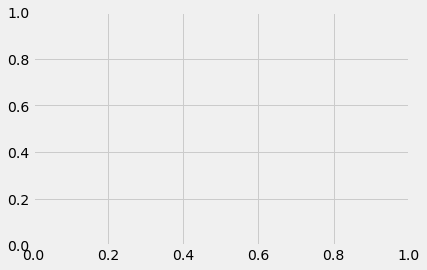

In [80]:
Distr_df.plot(kind='scatter', x='Distr_id', y = 'pr_med', c = Distr_df.bin_cat)

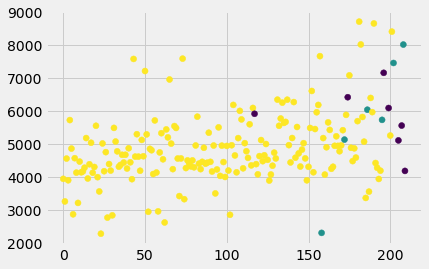

In [81]:
plt.scatter(Distr_df['Distr_id'], Distr_df['pr_med'], c= Distr_df.bin_cat)

In [43]:
Distr_df.pr_med.describe()

count     205.000000
mean     4892.045358
std      1095.528345
min      2273.498737
25%      4262.324104
50%      4708.779313
75%      5445.489427
max      8700.768533
Name: pr_med, dtype: float64

In [82]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.neighbors import KNeighborsClassifier

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
X_small = X_train_scaled[['total_rooms', 'total_bedrooms']]

pca = PCA(n_components=1, random_state=42)
X_small['component_1'] = pca.fit_transform(X_small)

plt.figure(figsize=(10,6))
plt.scatter(X_small.total_rooms,  X_small.total_bedrooms)
plt.show()

In [84]:
def reduce_dims(df, dims=2, method='pca', perplexity=30):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

In [85]:
dim_reducer2d, components_2d = reduce_dims(df, dims=2, method='pca')
components_2d.head(2)

ValueError: could not convert string to float: 'B'